In [1]:
import sys
import os
import json
import tensorflow as tf
import tqdm
from models.model import *
from ltv_utils import *
from losses.custom_loss import *
pd.set_option('display.float_format', '{:.4f}'.format)  # 保留10位小数，可调整
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)



def parse_function(serialized_example):
    feature_description = {
        'deviceid': tf.io.FixedLenFeature([], tf.string),
        'install_date': tf.io.FixedLenFeature([], tf.string),
        'dim_os_name1': tf.io.FixedLenFeature([], tf.string),
        'creative_classify1': tf.io.FixedLenFeature([], tf.string),
        'total_pay_amount1':  tf.io.FixedLenFeature([], tf.float32),
         'channel1': tf.io.FixedLenFeature([], tf.string),
        'b2_sale_amt_bias':  tf.io.FixedLenFeature([], tf.int64),
         'b2_sale_amt_7d': tf.io.FixedLenFeature([], tf.int64),
         'install_time': tf.io.FixedLenFeature([], tf.string),
        'install_order_diff':  tf.io.FixedLenFeature([], tf.int64),
        'all_install_order_7d_diff':  tf.io.FixedLenFeature([], tf.int64),
        'is_a1x_a33':  tf.io.FixedLenFeature([], tf.int64),
        'platform_label':  tf.io.FixedLenFeature([], tf.string),
        'user_dense_price_features': tf.io.FixedLenFeature([len(group_2_features['user_dense_price_features'])], tf.float32),
        'user_dense_duration_features': tf.io.FixedLenFeature([len(group_2_features['user_dense_duration_features'])], tf.float32),
        'user_dense_features': tf.io.FixedLenFeature([len(group_2_features['user_dense_features'])], tf.float32),
        'user_sparse_features': tf.io.FixedLenFeature([len(group_2_features['user_sparse_features'])], tf.float32)
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    return example


# load tf records
group_2_features = read_feature_json_config('features/feature_list.json')

train_file_name = 'data/ltv_0522_0603_multi_window_model_train/part-r-00000'
valid_file_name = 'data/ltv_0522_0603_multi_window_model_valid/part-r-00000'

train_dataset, valid_dataset, _ = get_trian_valid_test_dateset(parse_function, 10000, train_file_name, valid_file_name)



user_dense_price_features = group_2_features['user_dense_price_features']
user_dense_duration_features = group_2_features['user_dense_duration_features']
user_dense_features = group_2_features['user_dense_features']
user_sparse_features = group_2_features['user_sparse_features']


In [2]:
MODEL_HOUR = 0 

In [3]:
def create_tf_dataset(dataset):
    sample_batch = next(iter(dataset))
    sample_data = {k: v for k, v in sample_batch.items() if k not in ['b2_sale_amt_7d', 'total_pay_amount1']}

    
    def generator():
        for batch in dataset:
            hour = tf.cast(tf.gather(batch['user_sparse_features'],  indices=0, axis = 1) - 1, tf.int64)    # shape: (batch_size,)
            b2_7d = tf.cast(tf.reshape(batch.pop('b2_sale_amt_7d'), (-1, 1)), tf.float32)
            # 将 b2_7d 中小于 0 的值替换为 0
            b2_7d = tf.maximum(b2_7d, 0.0)
            
            total_amt_1h = tf.reshape(batch.pop('total_pay_amount1'), (-1, 1))

            # 只保留 hour 为 MODEL_HOUR 的记录
            hour_mask = tf.equal(hour, MODEL_HOUR)  # shape: (batch_size,)
            hour_mask = tf.reshape(hour_mask, (-1, 1))  # 广播成 (batch_size, 1)
            
            #  使用 hour_mask 筛选 batch 中的 对应小时窗口 
            selected_indices = tf.where(hour_mask)[:, 0]  # 获取 hour == 1 的样本索引
            batch = {k: tf.gather(v, selected_indices, axis=0) for k, v in batch.items()}  # 筛选 batch 中的样本
            b2_7d = tf.gather(b2_7d, selected_indices, axis=0)  # 保留 hour == 1 对应的标签
            total_amt_1h = tf.gather(total_amt_1h, selected_indices, axis=0)  # 保留 hour == 1 对应的标签

            # # 给某个小时 增加 真实值，测一下期望拟合
            # hour_mask = tf.equal(hour, 4)  # shape: (batch_size,)
            # hour_mask = tf.reshape(hour_mask, (-1, 1))  # 广播成 (batch_size, 1)
            # # ✅ 对应位置加 10000
            # b2_7d = tf.where(hour_mask, b2_7d + 10000.0, b2_7d)

            
    
            # 将保留的样本和标签一起返回
            y_true_packed = tf.concat([b2_7d, total_amt_1h], axis=1)

            # y_true_packed = b2_7d
            yield batch, y_true_packed
        

    # 正确写法：output_signature 中保留每个字段的真实 shape
    output_signature = (
        {
            name: tf.TensorSpec(shape=(None,) + v.shape[1:], dtype=v.dtype)
            for name, v in sample_data.items()
        },
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
    )

    return tf.data.Dataset.from_generator(generator, output_signature=output_signature)

In [4]:

emb_features = [
'creative_classify','dim_device_manufacture', 'car_add_type_most','show_order_is_2arrival_latest', 'selecttirecount_most', 'show_order_is_2arrival_most','selecttirecount_latest',
 'new_sitename','advsite','car_add_type_latest','platform_level', 'tire_list_click_avg_index','tire_list_click_most_pid_level','tire_order_page_most_pid_level',
]

sample = next(iter(train_dataset))
input_shape = {k: v.shape for k, v in sample.items()}


In [16]:
# #多头model
# model = MULTI_HEAD_LTV_MODEL(5, [160], [100], 'user_dense_features', 'user_dense_price_features', 'user_dense_duration_features',
#                             'user_sparse_features',user_sparse_features, emb_features)

model = Single_HEAD_LTV_MODEL(5, [160], [100], 'user_dense_features', 'user_dense_price_features', 'user_dense_duration_features',
                            'user_sparse_features',user_sparse_features, emb_features)
Single_HEAD_LTV_MODEL
# 自己实现的双口loss
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # 监控验证集上的 loss
    patience=3,          # 如果连续 3 轮没有改善，就停止训练
    restore_best_weights=True  # 训练结束后恢复到最优模型
)

loss_fn = UnifiedLTVLoss('delta')
model.compile(loss=loss_fn, 
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),  
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
             )


In [17]:
model.fit(
    create_tf_dataset(train_dataset),
    epochs=20,
    validation_data = create_tf_dataset(valid_dataset),
    callbacks= [early_stopping]
) 

Epoch 1/20
(None, 120)
(None, 120)
(None, 120)nown - 20s 79ms/step - rmse: 28987.2031
248/248 [==============================] - 23s 91ms/step - rmse: 28987.2031 - val_loss: 139345.0938 - val_rmse: 376.7098
Epoch 2/20
248/248 [==============================] - 23s 91ms/step - rmse: 363.5146 - val_loss: 114527.4453 - val_rmse: 342.9494
Epoch 3/20
248/248 [==============================] - 26s 105ms/step - rmse: 299.4290 - val_loss: 80515.5703 - val_rmse: 289.5388
Epoch 4/20
248/248 [==============================] - 24s 96ms/step - rmse: 274.9576 - val_loss: 75048.0469 - val_rmse: 280.6960
Epoch 5/20
248/248 [==============================] - 25s 101ms/step - rmse: 265.1769 - val_loss: 86640.0859 - val_rmse: 302.7301
Epoch 6/20
248/248 [==============================] - 23s 93ms/step - rmse: 326.9349 - val_loss: 879110.2500 - val_rmse: 936.6517
Epoch 7/20
248/248 [==============================] - 23s 93ms/step - rmse: 433.5673 - val_loss: 69189.2422 - val_rmse: 272.4338
Epoch 8/20
248/

In [18]:
model.evaluate_exp(create_tf_dataset(valid_dataset))

(2000, 120)
(1954, 120)
(1927, 120)
(2009, 120)
(1962, 120)
(2068, 120)
(1991, 120)
(2024, 120)
(1978, 120)
(2005, 120)
(1982, 120)
(1987, 120)
(1987, 120)
(1999, 120)
(1991, 120)
(1961, 120)
(2029, 120)
(2052, 120)
(2044, 120)
(2017, 120)
(2031, 120)
(2063, 120)
(1969, 120)
(2034, 120)
(2041, 120)
(1943, 120)
(1969, 120)
(1983, 120)
(1997, 120)
(2049, 120)
(1973, 120)
(2008, 120)
(2025, 120)
(1971, 120)
(2008, 120)
(1184, 120)


{'pred_sum': {0: 5093339.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0},
 'true_sum': {0: 4955362.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0},
 'bias': {0: 0.03, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}}

(2000, 120)
(1954, 120)
(1927, 120)
(2009, 120)
(1962, 120)
(2068, 120)
(1991, 120)
(2024, 120)
(1978, 120)
(2005, 120)
(1982, 120)
(1987, 120)
(1987, 120)
(1999, 120)
(1991, 120)
(1961, 120)
(2029, 120)
(2052, 120)
(2044, 120)
(2017, 120)
(2031, 120)
(2063, 120)
(1969, 120)
(2034, 120)
(2041, 120)
(1943, 120)
(1969, 120)
(1983, 120)
(1997, 120)
(2049, 120)
(1973, 120)
(2008, 120)
(2025, 120)
(1971, 120)
(2008, 120)
(1184, 120)


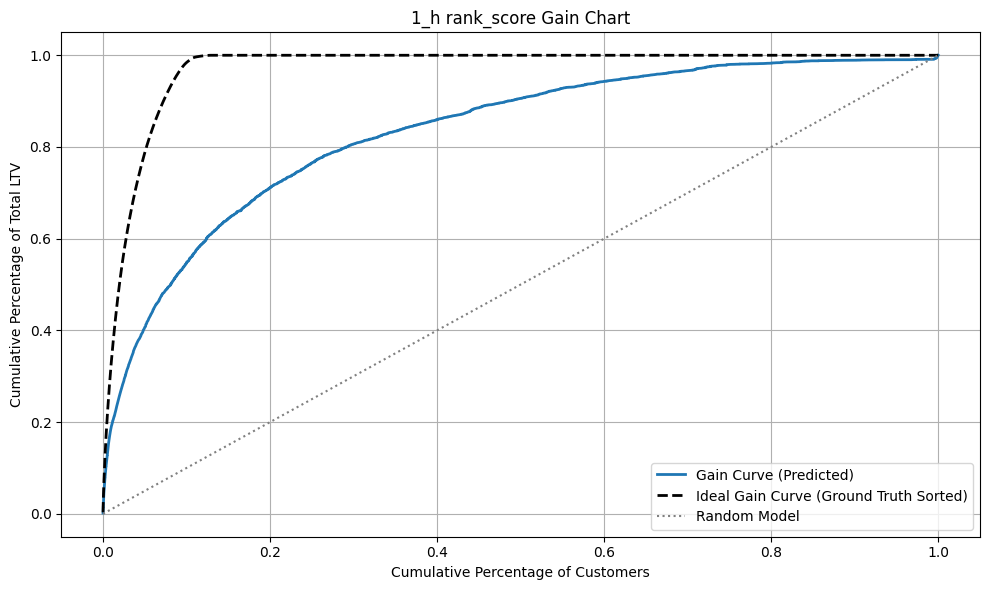

In [19]:
hour_model_pred = model.evaluate_rank(create_tf_dataset(valid_dataset))

In [20]:
hour_model_pred

{'1_h rank_score': 0.8333957023348806}

In [ ]:

for t1 in 